In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, maxabs_scale
from sklearn.model_selection import GridSearchCV,  RandomizedSearchCV
from sklearn.externals import joblib
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier

In [132]:
#Get data from CSV

train = pd.read_csv('/Users/macbook975/Documents/Projet/Apprentissage/train.csv')
test = pd.read_csv('/Users/macbook975/Documents/Projet/Apprentissage/test.csv')
sampleSubmission = pd.read_csv('/Users/macbook975/Documents/Projet/Apprentissage/sampleSubmission.csv')

In [ ]:
train[:5]

In [ ]:
test[:5]

# Data Visualisation

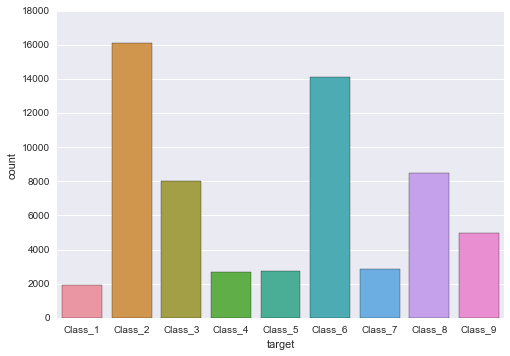

In [133]:
#Display Number of Sample/Label => Unbalanced Class

sns.set(style="darkgrid")
sns.countplot(x="target", data=train)

('Maximum value: ', 352)
('Minimum value: ', 0)


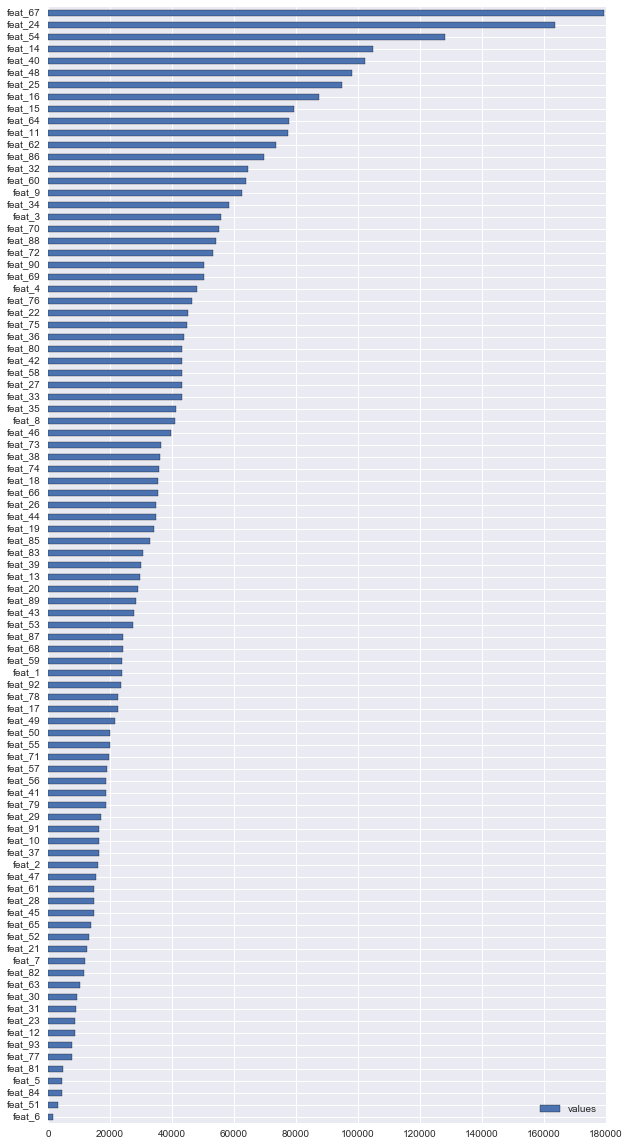

In [134]:
#Display Sum of Feature => Pre-processing data

features = pd.DataFrame(train.sum()[1:-1])
features.columns = ['values']

print("Maximum value: ", train[train.columns[1:-1]].max().max())
print("Minimum value: ", train[train.columns[1:-1]].min().min())

features.sort_values('values', ascending=True).plot(kind='barh', figsize=(10,20))

# Pre-Processing

In [135]:
#Make train, test set

xTrain = train[train.columns[1:-1]]
xTest = test[test.columns[1:]]
yTrain = LabelEncoder().fit_transform(train['target'])

In [ ]:
#Make train, test set - PreProcessing Data with StandardScaler

preprocessingTrain = StandardScaler().fit_transform(train[train.columns[1:-1]])
xTrain = pd.DataFrame(preprocessingTrain)

preprocessingTest = StandardScaler().fit_transform(test[test.columns[1:]])
xTest = pd.DataFrame(preprocessingTest)

yTrain = LabelEncoder().fit_transform(train['target'])

In [ ]:
#Make train, test set - PreProcessing Data with maxabs_scale

preprocessingTrain = maxabs_scale(train[train.columns[1:-1]], axis=0, copy=True)
xTrain = pd.DataFrame(preprocessingTrain)

preprocessingTest = maxabs_scale(test[test.columns[1:]], axis=0, copy=True)
xTest = pd.DataFrame(preprocessingTest)

yTrain = LabelEncoder().fit_transform(train['target'])

In [ ]:
# Find good features 

goodFeatures = []
goodFeaturesName = []

model = ExtraTreesClassifier()
model.fit(xTrain, yTrain)

features = model.feature_importances_
#np.mean(features)

for feature in range(len(features)):
    if(features[feature] > np.mean(features)/2):
        col_name = str("feat_{}".format(feature+1))
        goodFeaturesName.append(col_name)
        goodFeatures.append(feature)
print('Good Features: ' , goodFeatures)
print('Good Features: ' , goodFeaturesName)
print('Number of Good Features: ' , len(goodFeatures))

In [ ]:
xTrain[:5]

In [ ]:
yTrain

In [ ]:
xTest[:5]

# Training

In [ ]:
# Estimator with LinearSVC

estimator = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                      C=1.0, multi_class='ovr', fit_intercept=True,
                      intercept_scaling=1, class_weight='balanced', verbose=0, random_state=None, max_iter=1000)

In [ ]:
# GridSearch with parameters

paramGrid = {"C": [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
             "loss":['hinge', 'squared_hinge'],
             "max_iter": [500, 1000, 5000, 10000],
             "tol": [0.00001, 0.0001, 0.001, 0.01, 0.1]  }

gridSearchCV = GridSearchCV(estimator=estimator, cv=10, param_grid=paramGrid)
gridSearchCV.fit(xTrain, yTrain)



In [ ]:
# GridSearch - Result table

pd.DataFrame(gridSearchCV.cv_results_)

In [ ]:
# Get Best Parameters and Score

print(gridSearchCV.best_score_)
print(gridSearchCV.best_params_)

In [ ]:
# Get Result from CalibratedClassifierCV with gridSearchCV

model =  CalibratedClassifierCV(base_estimator=gridSearchCV, method='sigmoid', cv=10)
model.fit(xTrain, yTrain)

In [ ]:
# Model Score for Training Set

model.score(xTrain, yTrain)
#model.score(xTrain[xTrain.columns[vars]], yTrain)

# Train directly

In [ ]:
estimator = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                      C=1.0, multi_class='ovr', fit_intercept=True, 
                      intercept_scaling=1, class_weight='balanced', verbose=0, random_state=None, max_iter=1000)

estimator.fit(xTrain, yTrain)

In [ ]:
model =  CalibratedClassifierCV(base_estimator=estimator, method='isotonic', cv=10)
model.fit(xTrain, yTrain)

In [ ]:
model.score(xTrain, yTrain)

# Export/Import Model

In [ ]:
# Export model

joblib.dump(model, 'modelLinearSVMKaggle.pkl')

In [ ]:
# Import Model

joblib.load(model, 'modelLinearSVMKaggle.pkl')

# Prediction

In [151]:
# Prediction 

prediction = model.predict_proba(xTest)

# Export Submission File

In [152]:
# Export Submission File

prediction = pd.DataFrame(prediction, index=sampleSubmission.id.values, columns=sampleSubmission.columns[1:])
prediction.to_csv('LinearSVCNoScaleC10.csv', index_label='id')

In [ ]:
#xTest = pd.concat([test['id'], preprocessingTest], axis=1)
#xTrain = pd.concat([train['id'], preprocessingTrain], axis=1)
#xTrain[xTrain.columns[vars]]

#RandomizedSearchCV(estimator, param_distributions, n_iter=10, scoring=None, fit_params=None, n_jobs=1, 
#                   iid=True, refit=True, cv=None, verbose=0, 
#                   pre_dispatch='2*n_jobs', random_state=None, error_score='raise', 
#                   return_train_score=True)


# Make predict_proba for LinearSVC
#scores = model.decision_function(xTest)
#prediction = 1.0 / (1.0 + np.exp(-scores))
#row_sums = prediction.sum(axis=1)
#prediction = prediction / row_sums[:, np.newaxis]

#paramGrid = {"C": [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#             "loss":['hinge', 'squared_hinge'],
#             "max_iter": [500, 1000, 5000, 10000],
#             "tol": [0.00001, 0.0001, 0.001, 0.01, 0.1]  }